In [37]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [38]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'

SMOOTH = False

SEED = 25811243



## 1. ETL

In [39]:
from src import spectrumloader as spl
from src import get_torch_loader as tlg
from src.modeltorch_template import NeuralNet,RamConv1d,RamLSTM,RamConv1d_bnmx,IntANN,IntRamLSTM,RamConv1d_mx
from src import trainResult_show as mtp

In [40]:
standard,data_all = spl.read_file('dataset/')

In [41]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [42]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [43]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [44]:
X_train_VR = spl.fluoresence_removal(X_trainall)
if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)

In [45]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

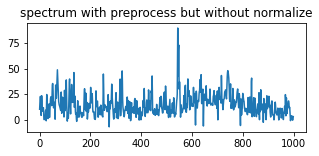

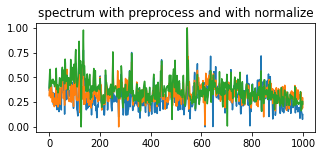

In [46]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

## 5. apply data to pytorch

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [48]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))



In [49]:
train_size = 12
val_size = 4
batch_size=12
valbatch_size=4
train_loader_all,val_loader_all = tlg.shuffleloadertorch(ds_earloop,ds_inarm,ds_thumbnail,ds_vain,SEED,train_size,val_size,batch_size,valbatch_size)

## 6. modeling
- ### 6.simple
    - ### ANN

In [50]:
model_for_earloop = NeuralNet(1000, 14, 2).to(device)
model_for_inarm = NeuralNet(1000, 14, 2).to(device)
model_for_thumbnail = NeuralNet(1000, 14, 2).to(device)
model_for_vain = NeuralNet(1000, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annsim_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [51]:
annsim_models[0]

NeuralNet(
  (fc1): Linear(in_features=1000, out_features=14, bias=True)
  (snm): Softmax(dim=1)
  (fc2): Linear(in_features=14, out_features=2, bias=True)
)

In [16]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000
train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []
for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(annsim_models,annsim_criterions,annsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')

    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [10000/10000], Step [1/1.0], Loss: 0.1043   ++++++Validation++++++  Loss: 1.63 - Acc: 25.00     ++++++Validation++++++  Loss: 1.35 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [10000/10000], Step [1/1.0], Loss: 0.1195   ++++++Validation++++++  Loss: 0.72 - Acc: 75.00    ++++++Validation++++++  Loss: 0.73 - Acc: 50.00     ++++++Validation++++++  Loss: 0.71 - Acc: 50.00     ++++++Validation++++++  Loss: 0.70 - Acc: 75.00     ++++++Validation++++++  Loss: 0.70 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [10000/10000], Step [1/1.0], Loss: 0.0939   ++++++Validation++++++  Loss: 0.78 - Acc: 50.00     ++++++Validation++++++  Loss: 0.69 - Acc: 50.00     ++++++Validation++++++  Loss: 0.70 - Acc: 50.00     ++++++Validation++++++  Loss: 0.76 - Acc: 50.00     ++++++Validation++++++  Loss: 0.78 - Acc: 50.00     ++++++Validation++++++  Loss: 0.78 - Acc: 50.00 
 END OF MODEL for thumb nail with val acc = 50.0
Epoch [10000/10000], Step [1/1.0], Loss:

#### loss plot

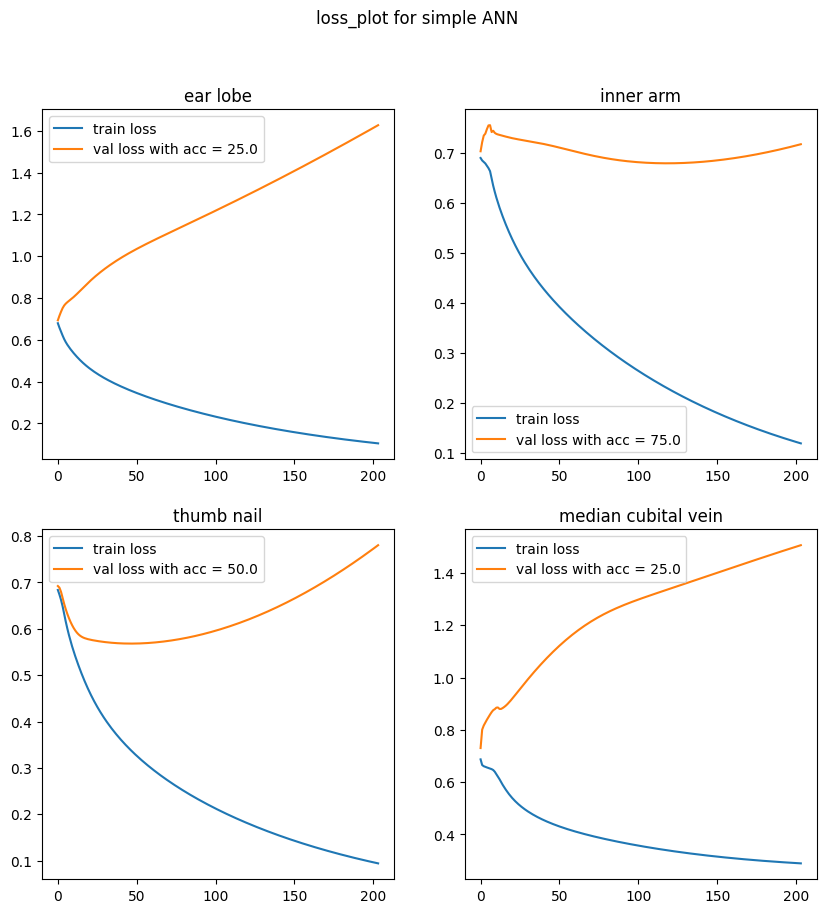

In [17]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple ANN')

- #### 6.Intermediate
    - ANN dropout

In [18]:
model_for_earloop = IntANN(1000, 14, 2).to(device)
model_for_inarm = IntANN(1000, 14, 2).to(device)
model_for_thumbnail = IntANN(1000, 14, 2).to(device)
model_for_vain = IntANN(1000, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annint_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annint_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annint_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [19]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000
train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []
for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(annint_models,annint_criterions,annint_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')

    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [10000/10000], Step [1/1.0], Loss: 0.3036   ++++++Validation++++++  Loss: 1.37 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [10000/10000], Step [1/1.0], Loss: 0.4178   ++++++Validation++++++  Loss: 1.05 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [10000/10000], Step [1/1.0], Loss: 0.3025   ++++++Validation++++++  Loss: 0.54 - Acc: 75.00    ++++++Validation++++++  Loss: 0.66 - Acc: 75.00     ++++++Validation++++++  Loss: 0.53 - Acc: 75.00     ++++++Validation++++++  Loss: 0.54 - Acc: 75.00 
 END OF MODEL for thumb nail with val acc = 75.0
Epoch [10000/10000], Step [1/1.0], Loss: 0.4699   ++++++Validation++++++  Loss: 1.37 - Acc: 25.00 
 END OF MODEL for median cubital vein with val acc = 25.0


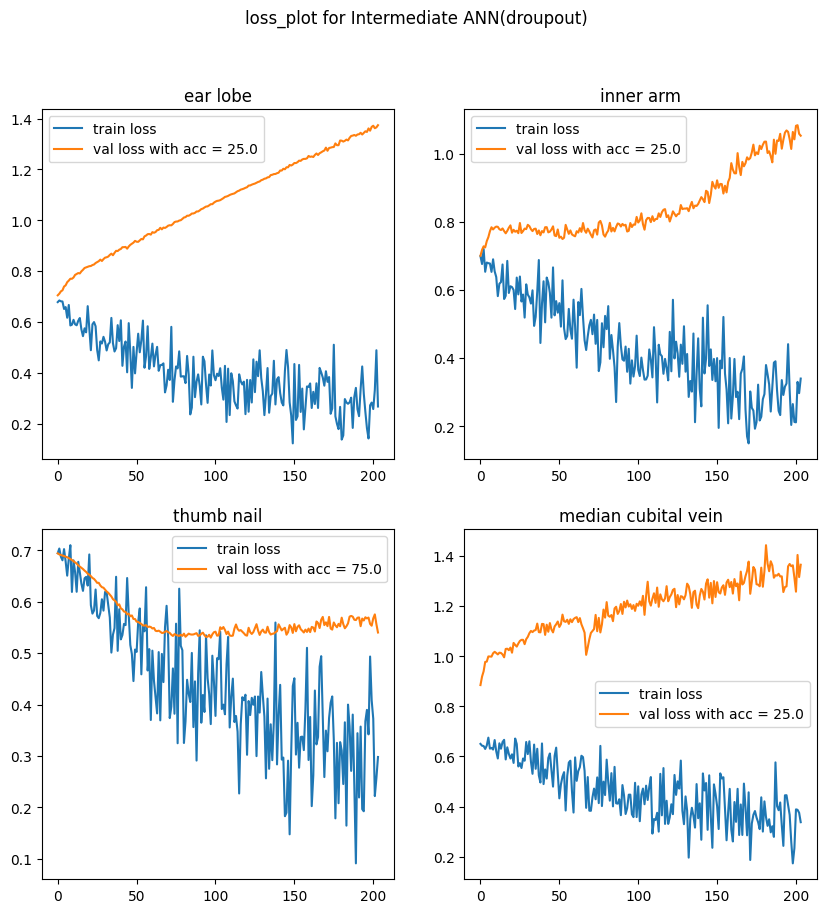

In [20]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'Intermediate ANN(droupout)')

- ### 6.simple
    - ### CNN

In [21]:
# .reshape(spec.shape[0],1,-1)

In [22]:
modelcnn_for_earloop = RamConv1d().to(device)
modelcnn_for_inarm = RamConv1d().to(device)
modelcnn_for_thumbnail = RamConv1d().to(device)
modelcnn_for_vain = RamConv1d().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [23]:
cnnsim_models[0]

RamConv1d(
  (conv1d): Conv1d(1, 50, kernel_size=(3,), stride=(1,))
  (linear1): Linear(in_features=49900, out_features=14, bias=True)
  (linear2): Linear(in_features=14, out_features=2, bias=True)
)

In [24]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnsim_models,cnnsim_criterions,cnnsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 5.82 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 5.84 - Acc: 25.00    ++++++Validation++++++  Loss: 2.08 - Acc: 25.00     ++++++Validation++++++  Loss: 4.47 - Acc: 25.00     ++++++Validation++++++  Loss: 5.62 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 1.13 - Acc: 50.00    ++++++Validation++++++  Loss: 0.50 - Acc: 75.00     ++++++Validation++++++  Loss: 0.69 - Acc: 75.00     ++++++Validation++++++  Loss: 1.07 - Acc: 50.00 
 END OF MODEL for thumb nail with val acc = 50.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 1.44 - Acc: 75.00 
 END OF MODEL for median cubital vein with val acc = 75.0


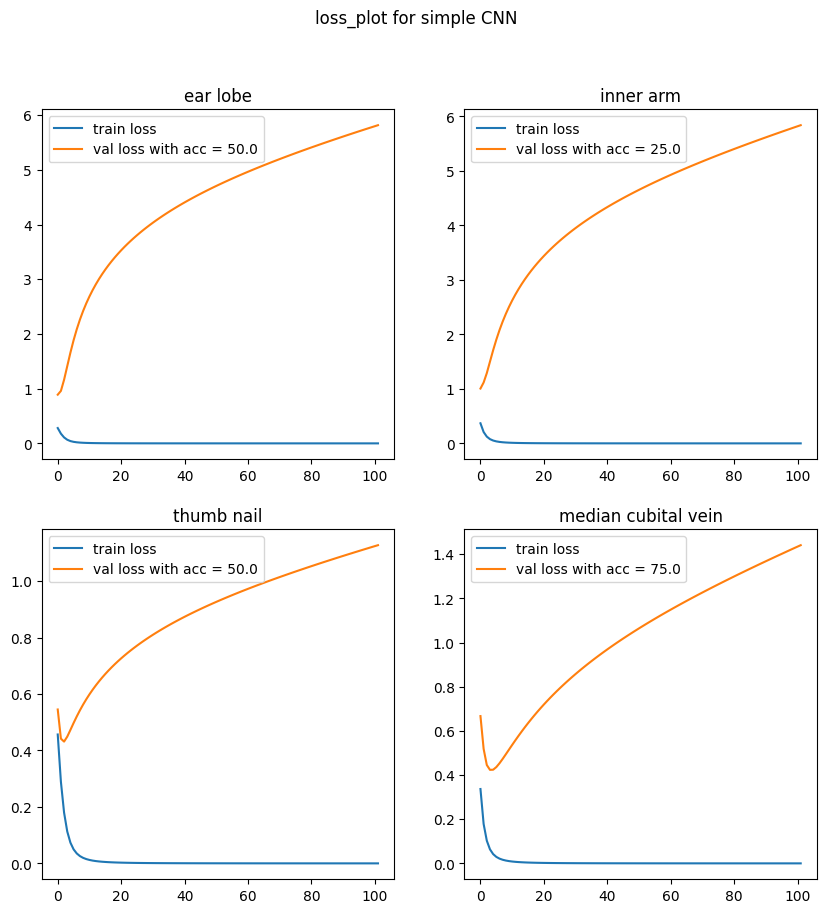

In [25]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',cnnsim_models[-1](spec),'\n',y,'\n val\n',cnnsim_models[-1](val_spec),val_label)

mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple CNN')

## 6.Intermediate

- ADV CNN
- BUILD by anh

In [26]:
modelcnn_for_earloop = RamConv1d_bnmx().to(device)
modelcnn_for_inarm = RamConv1d_bnmx().to(device)
modelcnn_for_thumbnail = RamConv1d_bnmx().to(device)
modelcnn_for_vain = RamConv1d_bnmx().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnINTsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnINTsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnINTsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [27]:
cnnINTsim_models[0]

RamConv1d_bnmx(
  (conv1): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(10, 50, kernel_size=(3,), stride=(1,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=12400, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=2, bias=True)
  (batchnorm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnINTsim_models,cnnINTsim_criterions,cnnINTsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            # print(spec.shape)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            model.eval()
            with torch.no_grad():
                
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())
                    
                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)
    

Epoch [1000/1000], Step [1/1.0], Loss: 0.0001   ++++++Validation++++++  Loss: 4.47 - Acc: 0.00 
 END OF MODEL for ear lobe with val acc = 0.0
Epoch [1000/1000], Step [1/1.0], Loss: 0.0001   ++++++Validation++++++  Loss: 3.06 - Acc: 0.00 
 END OF MODEL for inner arm with val acc = 0.0
Epoch [1000/1000], Step [1/1.0], Loss: 0.0001   ++++++Validation++++++  Loss: 1.06 - Acc: 50.00 
 END OF MODEL for thumb nail with val acc = 50.0
Epoch [1000/1000], Step [1/1.0], Loss: 0.0001   ++++++Validation++++++  Loss: 0.72 - Acc: 50.00     ++++++Validation++++++  Loss: 0.77 - Acc: 50.00 
 END OF MODEL for median cubital vein with val acc = 50.0


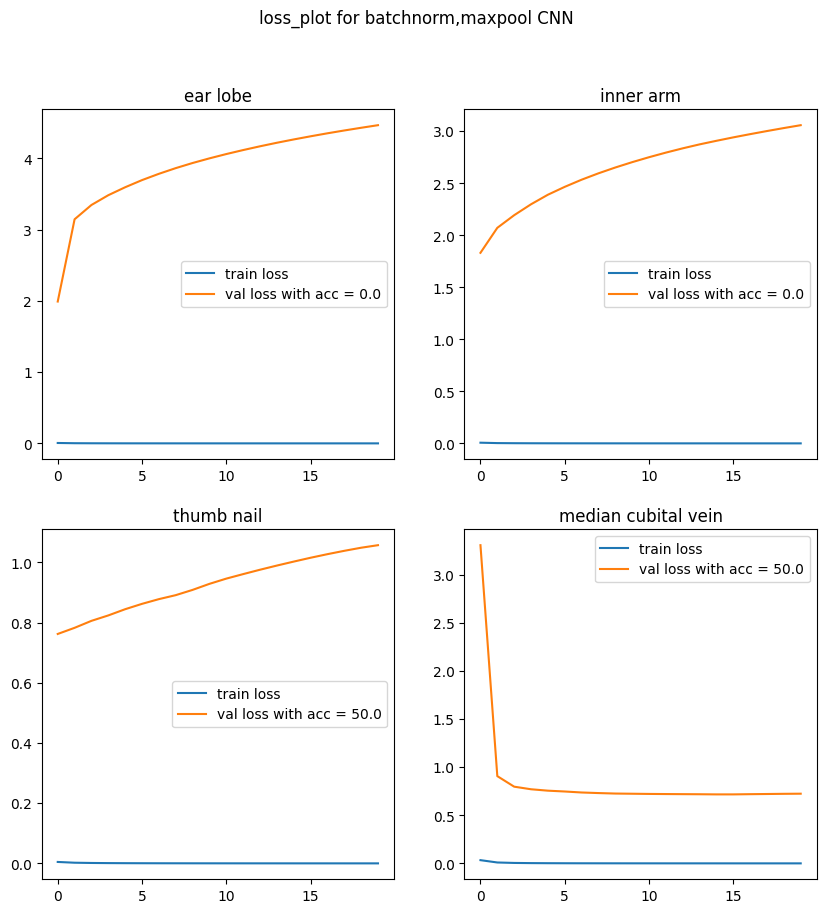

In [29]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'batchnorm,maxpool CNN')

- ### int CNN
    - with out batchnorm
    

In [ ]:
modelcnn_for_earloop = RamConv1d_mx().to(device)
modelcnn_for_inarm = RamConv1d_mx().to(device)
modelcnn_for_thumbnail = RamConv1d_mx().to(device)
modelcnn_for_vain = RamConv1d_mx().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnINTsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnINTsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnINTsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [ ]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnINTsim_models,cnnINTsim_criterions,cnnINTsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            # print(spec.shape)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            model.eval()
            with torch.no_grad():
                
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())
                    
                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)
    

- ### 6.simple
    - RNN

In [30]:
model_RNN_for_earloop = RamLSTM().to(device)
model_RNN_for_inarm = RamLSTM().to(device)
model_RNN_for_thumbnail = RamLSTM().to(device)
model_RNN_for_vain = RamLSTM().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [31]:
simRNN_models[0]

RamLSTM(
  (lstm): LSTM(1000, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)

In [32]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 5.82 - Acc: 25.00     ++++++Validation++++++  Loss: 4.46 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 1.89 - Acc: 75.00     ++++++Validation++++++  Loss: 1.52 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 1.04 - Acc: 50.00     ++++++Validation++++++  Loss: 0.99 - Acc: 50.00 
 END OF MODEL for thumb nail with val acc = 50.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 4.66 - Acc: 50.00 
 END OF MODEL for median cubital vein with val acc = 50.0


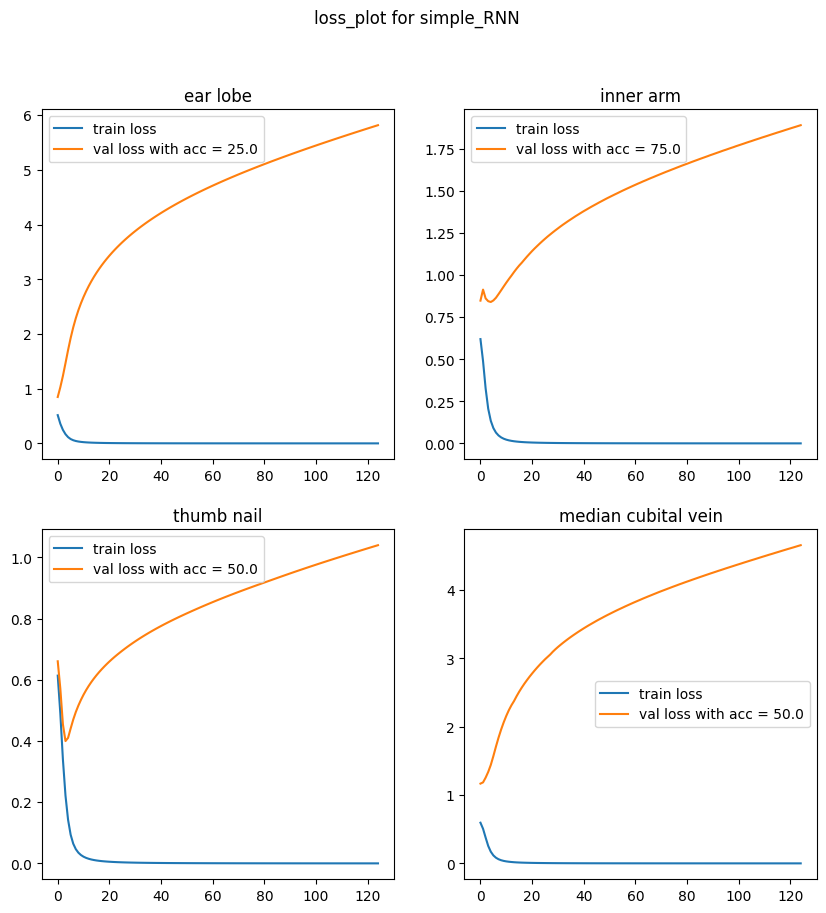

In [33]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple_RNN')

- ### 6. Intermediate
    - RNN Dropout

In [34]:
model_RNN_for_earloop = IntRamLSTM().to(device)
model_RNN_for_inarm = IntRamLSTM().to(device)
model_RNN_for_thumbnail = IntRamLSTM().to(device)
model_RNN_for_vain = IntRamLSTM().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

intRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
intRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
intRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [35]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(intRNN_models,intRNN_criterions,intRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            
            model.train()
            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 5.01 - Acc: 25.00     ++++++Validation++++++  Loss: 4.13 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 1.67 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0000    ++++++Validation++++++  Loss: 1.09 - Acc: 75.00 
 END OF MODEL for thumb nail with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 3.72 - Acc: 25.00    ++++++Validation++++++  Loss: 1.85 - Acc: 50.00     ++++++Validation++++++  Loss: 3.25 - Acc: 25.00 
 END OF MODEL for median cubital vein with val acc = 25.0


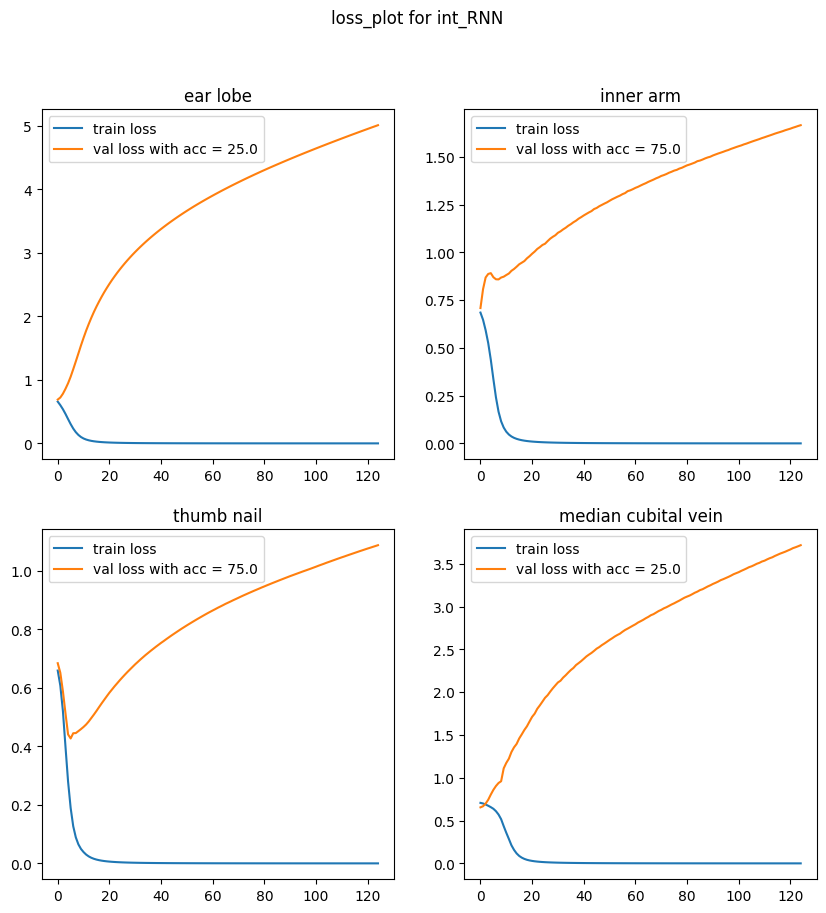

In [37]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'int_RNN')